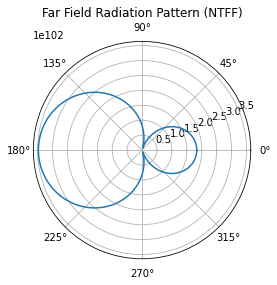

In [1]:
# --- Full 2D FDTD with NTFF ---

import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
eps0 = 1
mu0 = 1
c0 = 1 / np.sqrt(mu0 * eps0)

# --- Simulation Parameters ---
dx = dy = 0.5e-3  # spatial step size (0.5 mm)
size_x = size_y = 100e-3  # domain size (100 mm)

numX = int(size_x / dx)
numY = int(size_y / dy)

# Time stepping
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 400

# Source parameters
lambda0 = 6e-2  # 60 mm wavelength
f0 = c0 / lambda0
omega0 = 2 * np.pi * f0
k0 = 2 * np.pi / lambda0

# Field arrays
Ez = np.zeros((numY, numX))
Hx = np.zeros((numY, numX))
Hy = np.zeros((numY, numX))

# --- Boundary indices for NTFF ---
buffer = 10  # cells from edges for integration boundary

L1_idxs = [(buffer, n) for n in range(buffer, numY - buffer)]
L2_idxs = [(m, numY - buffer - 1) for m in range(buffer, numX - buffer)]
L3_idxs = [(numX - buffer - 1, n) for n in range(buffer, numY - buffer)]
L4_idxs = [(m, buffer) for m in range(buffer, numX - buffer)]

# --- Recording boundary fields over time ---
Ez_time_L1 = np.zeros((len(L1_idxs), max_time_steps), dtype=complex)
Hx_time_L1 = np.zeros((len(L1_idxs), max_time_steps), dtype=complex)
Hy_time_L1 = np.zeros((len(L1_idxs), max_time_steps), dtype=complex)

# --- FDTD Main Loop ---

for t in range(max_time_steps):

    # Update H fields
    Hx[:-1, :] -= (Ez[1:, :] - Ez[:-1, :]) * magic_time_step / (mu0 * dx)
    Hy[:, :-1] += (Ez[:, 1:] - Ez[:, :-1]) * magic_time_step / (mu0 * dy)

    # Update E field
    curl_H = (Hy[1:,1:] - Hy[:-1,1:]) - (Hx[1:,1:] - Hx[1:,:-1])
    Ez[1:,1:] += (magic_time_step / (eps0 * dx)) * curl_H

    # Source excitation (point source at center)
    Ez[numY//2, numX//2] += np.sin(omega0 * t * magic_time_step)

    # Record fields on L1 boundary
    for idx, (m, n) in enumerate(L1_idxs):
        Ez_time_L1[idx, t] = Ez[n, m]
        Hx_time_L1[idx, t] = 0.5 * (Hx[n, m] + Hx[n-1, m])  # geometric mean approx
        Hy_time_L1[idx, t] = 0.5 * (Hy[n, m] + Hy[n, m-1])

# --- Perform FFT after FDTD ---
frequencies = np.fft.fftfreq(max_time_steps, d=magic_time_step)
target_idx = np.argmin(np.abs(frequencies - f0))

Ez_fft = np.fft.fft(Ez_time_L1, axis=1)
Hx_fft = np.fft.fft(Hx_time_L1, axis=1)
Hy_fft = np.fft.fft(Hy_time_L1, axis=1)

Ez_L1_f = Ez_fft[:, target_idx]
Hx_L1_f = Hx_fft[:, target_idx]
Hy_L1_f = Hy_fft[:, target_idx]

# --- Generate boundary points ---

def generate_boundary_coords(Ez_f, Hx_f, Hy_f, L1_idxs, delta):
    boundary_coords = []
    for idx, (m, n) in enumerate(L1_idxs):
        x_p = m * delta
        y_p = n * delta
        n_x, n_y = -1, 0  # normal vector for left side
        boundary_coords.append((x_p, y_p, n_x, n_y, Ez_f[idx], Hx_f[idx], Hy_f[idx]))
    return boundary_coords

boundary_coords = generate_boundary_coords(Ez_L1_f, Hx_L1_f, Hy_L1_f, L1_idxs, dx)

# --- NTFF Calculation ---

def compute_ntff(boundary_coords, delta, freq, eps0=eps0, mu0=mu0):
    c0 = 1 / np.sqrt(mu0 * eps0)
    lambda0 = c0 / freq
    k0 = 2 * np.pi / lambda0
    eta0 = np.sqrt(mu0/eps0)

    phi_obs = np.linspace(0, 2*np.pi, 360)
    Ez_far = np.zeros_like(phi_obs, dtype=complex)

    for idx, phi in enumerate(phi_obs):
        integral_sum = 0
        for (x_p, y_p, n_x, n_y, Ez_p, Hx_p, Hy_p) in boundary_coords:
            J_dot_z = n_x * Hy_p - n_y * Hx_p
            M_dot_phi = (n_y * np.sin(phi) + n_x * np.cos(phi)) * Ez_p
            phase = k0 * (x_p * np.cos(phi) + y_p * np.sin(phi))
            exp_phase = np.exp(1j * phase)
            integrand = (eta0 * J_dot_z - M_dot_phi) * exp_phase * delta
            integral_sum += integrand

        Ez_far[idx] = (-1) * np.sqrt(1j/(8*np.pi*k0)) * integral_sum

    return phi_obs, Ez_far

phi_obs, Ez_far = compute_ntff(boundary_coords, delta=dx, freq=f0)

# --- Plot Far Field Pattern ---
plt.figure()
plt.polar(phi_obs, np.abs(Ez_far))
plt.title('Far Field Radiation Pattern (NTFF)')
plt.show()
